In [1]:
import rasterio
import numpy as np
import matplotlib as mpl
import subprocess
from matplotlib import pyplot
from rasterio.merge import merge
import geopandas as gpd

## Merge GeoTIFF Data of each Band

In [2]:
file1 = 'LC08_L1TP_126051_20171206_20171223_01_T1'
file2 = 'LC08_L1TP_127051_20171213_20171223_01_T1'

list1 = ['Data/B5/' + file1 + '_B5.TIF',
         'Data/B4/' + file1 + '_B4.TIF']
list2 = ['Data/B5/' + file2 + '_B5.TIF',
        'Data/B4/' + file2 + '_B4.TIF']

date = '201712'

outFile = ['NDVI/' + date + '/' + 'NIR.TIF',
           'NDVI/' + date + '/' + 'RED.TIF']

for i in range(2):
    listFile = [rasterio.open(f) for f in [list1[i], list2[i]]]

    dest, output_transform = merge(listFile)

    profile = listFile[0].profile
    profile['transform'] = output_transform
    profile['height'] = dest.shape[1]
    profile['width'] = dest.shape[2]

    with rasterio.open(outFile[i], 'w', **profile) as dst:
        dst.write(dest)
        try:
            colormap = listFile[0].colormap(1)
            dst.write_colormap(1, colormap)
        except ValueError:
            pass

## Calculate NDVI

In [3]:
date = '201612'
listFile = ['NDVI/' + date + '/NIR.TIF',
           'NDVI/' + date + '/RED.TIF']

bandNIR, bandRed = (rasterio.open(f) for f in listFile)

bandNIR = bandNIR.read(1)
bandRed = bandRed.read(1)

NDVI = np.zeros(rasterio.open(listFile[0]).shape, dtype=rasterio.float32)

In [4]:
import math
for i in range(NDVI.shape[0]):
    for j in range(NDVI.shape[1]):
        nir = bandNIR[i,j].astype(float)
        red = bandRed[i,j].astype(float)
        NDVI[i,j] = (nir - red) / (nir + red)
        if math.isnan(NDVI[i,j]):
           NDVI[i,j] = 1
        

/home/ahldt/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


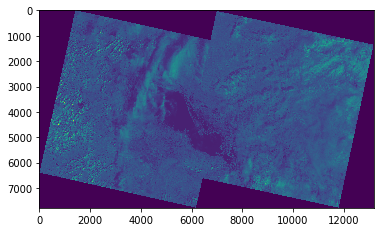

In [5]:
pyplot.imshow(bandNIR)

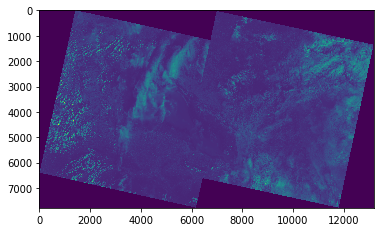

In [6]:
pyplot.imshow(bandRed)

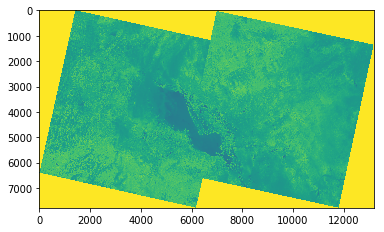

In [7]:
pyplot.imshow(NDVI)

In [8]:
src = rasterio.open(listFile[0])
meta = src.meta
meta['dtype'] = 'float32'
with rasterio.open('NDVI.TIF', 'w', **meta) as dst:
    dst.write(NDVI, 1)

/home/ahldt/.local/lib/python3.6/site-packages/rasterio/__init__.py:160: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)


In [9]:
src = rasterio.open('NDVI.TIF')

## Read Shapefile

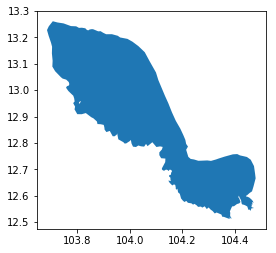

In [2]:
cambodia_waterbodies_path = 'water-bodies-09-08-2016'
df = gpd.read_file(cambodia_waterbodies_path)
tonlesap = df[df.name == 'Boeung Tonle Sap']
tonlesap.plot();

In [3]:
from rasterio.crs import CRS
from rasterio.warp import transform_geom
from shapely.geometry import shape, mapping, Polygon, MultiPolygon
from matplotlib.collections import PatchCollection
from descartes import PolygonPatch

In [4]:
# This function draw a list of geometry objects onto AX object
def plot_shapes(shapes, ax=None, overlay=False):

    cm = plt.get_cmap('jet')
    num_colors = len(shapes)

    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)

    mp = MultiPolygon(shapes)

    xmin, ymin, xmax, ymax = mp.bounds
    w, h = xmax - xmin, ymax - ymin

    ax.set_xlim(xmin - 0.2 * w, xmax + 0.2 * w)
    ax.set_ylim(ymin - 0.2 * h, ymax + 0.2 * h)
    ax.set_aspect(1.0)

    patches = []
    for idx, p in enumerate(shapes):
        color = cm(1. * idx/num_colors)
        if overlay:
            patches.append(PolygonPatch(p, fc='none', ec='#555555', zorder=1))
        else:
            patches.append(PolygonPatch(p, fc=color, ec='#555555', alpha=.5, zorder=1))
    ax.add_collection(PatchCollection(patches, match_original=True))
    return ax

In [10]:
src = rasterio.open('NDVI.TIF')
trans = src.transform
%matplotlib inline

/home/anhldt/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2910: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [12]:
tonlesap_shape = tonlesap.geometry.values[0]
onlesap_geom = mapping(tonlesap_shape)

In [14]:
import rasterio.mask
tonlesap_shape = [transform_geom(df.crs, src.crs, tonlesap_geom)]
red, trans = rasterio.mask.mask(src, tonlesap_shape, crop=True)
crs = src.crs
trans = src.transform
bounds = src.bounds
meta = src.meta.copy()

/home/anhldt/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2910: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [19]:
nir, _ = rasterio.mask.mask(src, tonlesap_shape, crop=True)

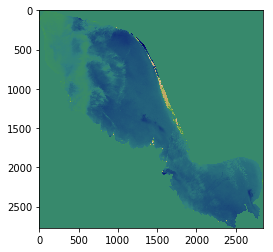

In [20]:
pyplot.imshow(nir.squeeze(), cmap=pyplot.cm.gist_earth);

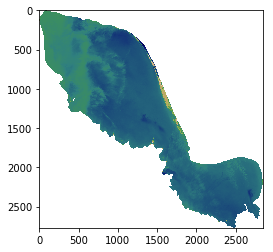

In [24]:
masked_nir = nir.squeeze()
masked_nir = np.ma.array(masked_nir, mask=(masked_nir==0), fill_value=0)
cmap = pyplot.cm.gist_earth
cmap.set_bad('white')
pyplot.imshow(masked_nir, cmap=cmap);